# Prova eEDB-002/2024-3

Importando bibliotecas necessárias para o desenvolvimento da prova. Os principais\
pacotes são [sklearn](https://scikit-learn.org/stable/) para treinamento do modelo; [numpy](https://numpy.org/) e [pandas](https://pandas.pydata.org/) para manipulação\
de dados e; [seaborn](https://seaborn.pydata.org/) e [matplotlib](https://matplotlib.org/) para geração de visualizaçãoes.

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

from datetime import datetime

import joblib
import numpy as np
import pandas as pd
import helper as hp
import seaborn as sns
import matplotlib.pyplot as plt

---
## Leitura dos dados

Importando dados em formato .xlsx para realizar a prova, considerando:
- Importando apenas a primeira pasta do arquivo "Question 1";
- ignorando as primeiras 18 linhas do arquivo (contando a partir de 0);
- Discriminando os valores faltantes "\<NA\>" e "?";
- Renomeando as colunas para _snake case_;
- Selectionando apenas as colunas desejadas "date", "total_sales" e "temperature_celsius";
- Convertendo o tipo das colunas para um mais apropriado.

In [6]:
ice_cream_sales = pd.read_excel(
    io='../data/eDB-002 - Exercicio - REG LINENAR.xlsx',
    sheet_name='Question 1',
    skiprows=18,
    na_filter=True,
    na_values=['<NA>', '?'],
    names=['date', 'temperature_fahrenheit', 'total_sales', 'temperature_celsius'],
    usecols=['date', 'total_sales', 'temperature_fahrenheit'],
    dtype={
        'date': 'datetime64[ns]',
        'total_sales': pd.Float64Dtype(),
        'temperature_fahrenheit': pd.Float64Dtype(),
    },
)

Removendo linhas com dados faltantes

In [7]:
ice_cream_sales.dropna(inplace=True)

Visualizando dados lidos do arquivo .xlsx

In [8]:
ice_cream_sales.head()

,date,temperature_fahrenheit,total_sales
0,2004-03-01,65.100035,38911.0
1,2004-03-02,62.832313,36337.258058
2,2004-03-03,62.088516,35728.110238
3,2004-03-04,65.105432,36945.386701
4,2004-03-05,63.011221,36335.166206


Conferindo tipo dos dados

In [9]:
ice_cream_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7175 entries, 0 to 7174
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    7175 non-null   datetime64[ns]
 1   temperature_fahrenheit  7175 non-null   Float64       
 2   total_sales             7175 non-null   Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 238.2 KB


---
## Engenharia de características

### 1) Criação de variaveis

#### 1.1) Crie uma variavel chamada: dia_da_semana e popule-na com (dom, seg, ter, etc)

In [10]:
ice_cream_sales['day_of_week'] = ice_cream_sales['date'].dt.strftime('%A')
ice_cream_sales.head()

,date,temperature_fahrenheit,total_sales,day_of_week
0,2004-03-01,65.100035,38911.0,Monday
1,2004-03-02,62.832313,36337.258058,Tuesday
2,2004-03-03,62.088516,35728.110238,Wednesday
3,2004-03-04,65.105432,36945.386701,Thursday
4,2004-03-05,63.011221,36335.166206,Friday


**Bonus**: Calculando a semana do mês para localizar os dados entre o começo, meio, ou fim de mês

In [65]:
ice_cream_sales['week_of_month'] = ice_cream_sales['date'].dt.day // 7 + 1
ice_cream_sales['week_of_month'] = ice_cream_sales['week_of_month'].astype(str) + 'th Week'
ice_cream_sales.tail()

,date,temperature_fahrenheit,total_sales,day_of_week,week_of_month,month_of_year,season,temperature_celsius,30_days_rolling_mean_sales,30_days_rolling_mean_temperature
7170,2023-10-18,65.003948,38978.352433,Wednesday,3th Week,October,Spring,18.335526,38678.442478,17.980053
7171,2023-10-19,66.153564,38974.683053,Thursday,3th Week,October,Spring,18.974202,38675.949082,18.001624
7172,2023-10-20,63.062093,38346.656668,Friday,3th Week,October,Spring,17.256718,38652.604553,17.972893
7173,2023-10-21,65.856644,38949.900053,Saturday,4th Week,October,Spring,18.809247,38649.442049,17.970813
7174,2023-10-22,71.161566,40465.584049,Sunday,4th Week,October,Spring,21.756425,38717.201235,18.098673


#### 1.2) Crie uma variavel chamada: mês_venda e popule-na com (jan,fev,mar,abr, etc)

In [14]:
ice_cream_sales['month_of_year'] = ice_cream_sales['date'].dt.strftime('%B')
ice_cream_sales.head()

,date,temperature_fahrenheit,total_sales,day_of_week,week_of_month,month_of_year
0,2004-03-01,65.100035,38911.0,Monday,1th,March
1,2004-03-02,62.832313,36337.258058,Tuesday,1th,March
2,2004-03-03,62.088516,35728.110238,Wednesday,1th,March
3,2004-03-04,65.105432,36945.386701,Thursday,1th,March
4,2004-03-05,63.011221,36335.166206,Friday,1th,March


**Bonus**: Calculando a estação do ano com base na data de aferição

```python
def get_season_as_string(date: datetime) -> str:
    """
    A function to determine the season of given a date, considering leap
    years. Besides, this function considers the southern hemisphere
    seasons. Finally, this function considers the day of the year insted
    of the absolute date in the format 'dd-MM-yyyy' for simplicity use.
    """
    is_leap_year = date.is_leap_year
    day_in_year = date.day_of_year
    season = ''

    seasons = seasons_dates['leap_year'] if is_leap_year else seasons_dates['normal_year']

    if seasons['autumn']['starts_at'] <= day_in_year < seasons['autumn']['ends_at']:
        season = 'Autumn'
    elif seasons['winter']['starts_at'] <= day_in_year < seasons['winter']['ends_at']:
        season = 'Winter'
    elif seasons['spring']['starts_at'] <= day_in_year < seasons['spring']['ends_at']:
        season = 'Spring'
    else:
        season = 'Summer'

    return season
```

In [15]:
ice_cream_sales['season'] = ice_cream_sales['date'].apply(hp.get_season_as_string)
ice_cream_sales

,date,temperature_fahrenheit,total_sales,day_of_week,week_of_month,month_of_year,season
0,2004-03-01,65.100035,38911.0,Monday,1th,March,Summer
1,2004-03-02,62.832313,36337.258058,Tuesday,1th,March,Summer
2,2004-03-03,62.088516,35728.110238,Wednesday,1th,March,Summer
3,2004-03-04,65.105432,36945.386701,Thursday,1th,March,Summer
4,2004-03-05,63.011221,36335.166206,Friday,1th,March,Summer
...,...,...,...,...,...,...,...
7170,2023-10-18,65.003948,38978.352433,Wednesday,3th,October,Spring
7171,2023-10-19,66.153564,38974.683053,Thursday,3th,October,Spring
7172,2023-10-20,63.062093,38346.656668,Friday,3th,October,Spring
7173,2023-10-21,65.856644,38949.900053,Saturday,4th,October,Spring


**Bonus**: Crie uma variavel com a temperatura em graus celsius (a partir da temperatura em fahrenheit) sem arredondamentos

In [16]:
ice_cream_sales['temperature_celsius'] = (ice_cream_sales['temperature_fahrenheit'] - 32) / 1.8
ice_cream_sales.head()

,date,temperature_fahrenheit,total_sales,day_of_week,week_of_month,month_of_year,season,temperature_celsius
0,2004-03-01,65.100035,38911.0,Monday,1th,March,Summer,18.388908
1,2004-03-02,62.832313,36337.258058,Tuesday,1th,March,Summer,17.129063
2,2004-03-03,62.088516,35728.110238,Wednesday,1th,March,Summer,16.715842
3,2004-03-04,65.105432,36945.386701,Thursday,1th,March,Summer,18.391907
4,2004-03-05,63.011221,36335.166206,Friday,1th,March,Summer,17.228456


**Bonus**: Criando uma variavel de média móvel de 30 dias do valor de vendas de sorvete

In [17]:
ice_cream_sales['30_days_rolling_mean_sales'] = ice_cream_sales['total_sales'].rolling(30).mean()
ice_cream_sales.tail()

,date,temperature_fahrenheit,total_sales,day_of_week,week_of_month,month_of_year,season,temperature_celsius,30_days_rolling_mean_sales
7170,2023-10-18,65.003948,38978.352433,Wednesday,3th,October,Spring,18.335526,38678.442478
7171,2023-10-19,66.153564,38974.683053,Thursday,3th,October,Spring,18.974202,38675.949082
7172,2023-10-20,63.062093,38346.656668,Friday,3th,October,Spring,17.256718,38652.604553
7173,2023-10-21,65.856644,38949.900053,Saturday,4th,October,Spring,18.809247,38649.442049
7174,2023-10-22,71.161566,40465.584049,Sunday,4th,October,Spring,21.756425,38717.201235


**Bonus**: Criando uma variavel de média móvel de 30 dias da temperatura em celsius

In [18]:
ice_cream_sales['30_days_rolling_mean_temperature'] = ice_cream_sales['temperature_celsius'].rolling(30).mean()
ice_cream_sales.tail()

,date,temperature_fahrenheit,total_sales,day_of_week,week_of_month,month_of_year,season,temperature_celsius,30_days_rolling_mean_sales,30_days_rolling_mean_temperature
7170,2023-10-18,65.003948,38978.352433,Wednesday,3th,October,Spring,18.335526,38678.442478,17.980053
7171,2023-10-19,66.153564,38974.683053,Thursday,3th,October,Spring,18.974202,38675.949082,18.001624
7172,2023-10-20,63.062093,38346.656668,Friday,3th,October,Spring,17.256718,38652.604553,17.972893
7173,2023-10-21,65.856644,38949.900053,Saturday,4th,October,Spring,18.809247,38649.442049,17.970813
7174,2023-10-22,71.161566,40465.584049,Sunday,4th,October,Spring,21.756425,38717.201235,18.098673


---
## Análise exploratória

### 2) Análises univariadas

#### 2.1) Análises descritivas

Calculando a quantidade de registros, média, desvio padrão, mínimo, máximo e os quartis\
para as variáveis quantitativas contínuas, i.e., "total_sales" e "temperature_celsius".

In [13]:
ice_cream_sales.drop(
    columns=[
        'date',
        'day_of_week',
        'month_of_year',
        'week_of_month',
        'temperature_fahrenheit',
        'season',
        '30_days_rolling_mean_sales',
        '30_days_rolling_mean_temperature'
    ]
).describe()

,total_sales,temperature_celsius
count,7175.0,7175.0
mean,40154.737143,23.282843
std,5642.698863,7.590269
min,28238.199588,5.454535
25%,36365.003731,16.723736
50%,39052.56443,23.50444
75%,45451.687339,30.056367
max,55022.578795,37.155757


#### 2.2) Análises graficas

Gráfico de violino com boxplot para descrever a distribuição de vendas de sorvete

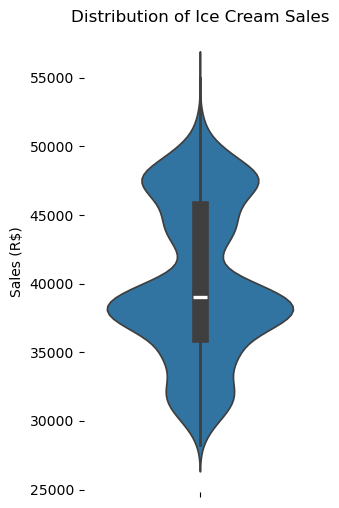

In [14]:
plt.subplots(figsize=(3, 6))

sns.violinplot(
    data=ice_cream_sales,
    y='total_sales',
    inner_kws=dict(box_width=12, whis_width=2)
)

plt.ylabel('Sales (R$)')
plt.title('Distribution of Ice Cream Sales')

sns.despine(left=True, bottom=True)

Gráfico de violino com boxplot para descrever a distribuição de temperatudas aferidas diariamente

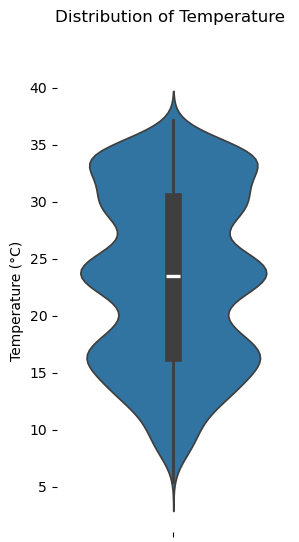

In [15]:
plt.subplots(figsize=(3, 6))

sns.violinplot(
    data=ice_cream_sales,
    y='temperature_celsius',
    inner_kws=dict(box_width=12, whis_width=2)
)

plt.ylabel('Temperature (°C)')
plt.suptitle('Distribution of Temperature')

sns.despine(left=True, bottom=True)

### 3) Análises bi-variadas

#### 3.1) Análise de vendas em relação a datas do ano

Analise sobre total de vendas em relação ao mês do ano. Neste contexto foi utilizado um\
gráfico de violino em que a linha tracejada ao meio representa a mediana; linha a cima o\
terceiro quartil; linha abaixo, primeiro quartil.

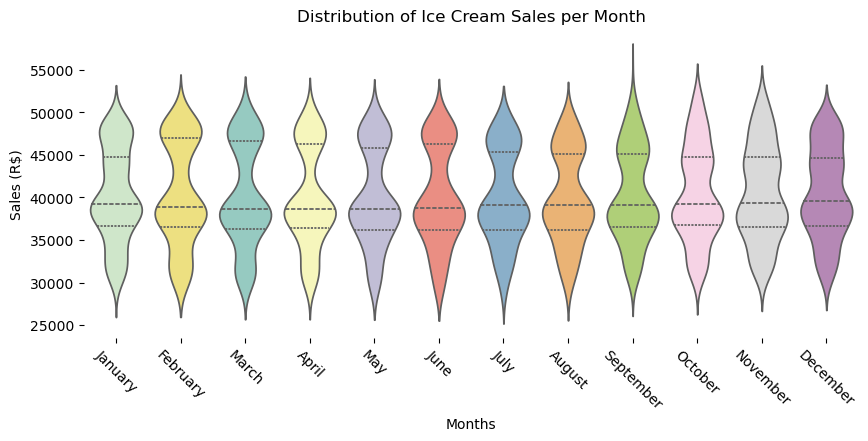

In [19]:
plt.subplots(figsize=(10, 4))

sns.violinplot(
    data=ice_cream_sales,
    x='month_of_year',
    y='total_sales',
    hue='month_of_year',
    palette='Set3',
    legend=False,
    inner='quart',
    order=[
        'January',
        'February',
        'March',
        'April',
        'May',
        'June',
        'July',
        'August',
        'September',
        'October',
        'November',
        'December'
    ]
)

plt.xticks(rotation=-45)
plt.xlabel('Months')
plt.ylabel('Sales (R$)')
plt.title('Distribution of Ice Cream Sales per Month')

sns.despine(left=True, bottom=True)

Analise sobre total de vendas em relação ao dia da semana. Neste contexto foi utilizado um\
gráfico de violino em que a linha tracejada ao meio representa a mediana; linha a cima o\
terceiro quartil; linha abaixo, primeiro quartil.

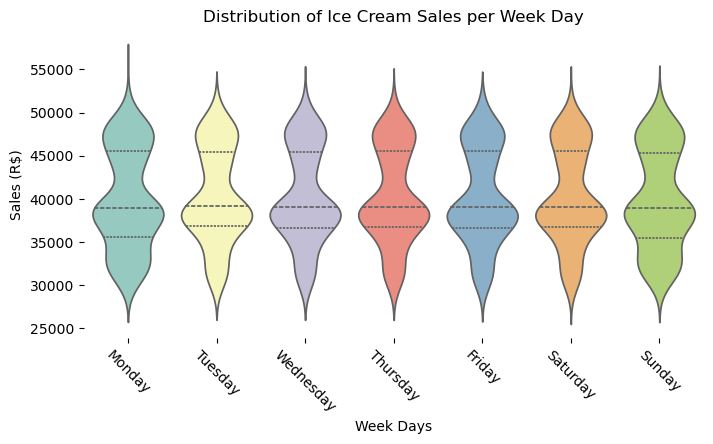

In [20]:
plt.subplots(figsize=(8, 4))

sns.violinplot(
    data=ice_cream_sales,
    x='day_of_week',
    y='total_sales',
    hue='day_of_week',
    palette='Set3',
    legend=False,
    inner='quart',
    order=[
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
        'Sunday'
    ]
)

plt.xticks(rotation=-45)
plt.xlabel('Week Days')
plt.ylabel('Sales (R$)')
plt.title('Distribution of Ice Cream Sales per Week Day')

sns.despine(left=True, bottom=True)

Analise sobre total de vendas em relação às semanas de mês. Neste contexto foi utilizado um\
gráfico de violino em que a linha tracejada ao meio representa a mediana; linha a cima o\
terceiro quartil; linha abaixo, primeiro quartil.

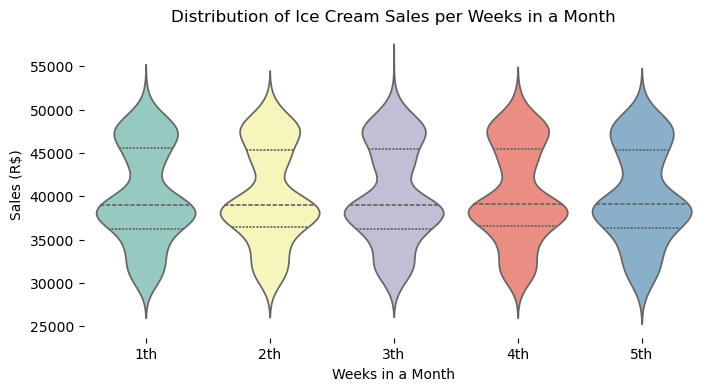

In [21]:
plt.subplots(figsize=(8, 4))

sns.violinplot(
    data=ice_cream_sales,
    x='week_of_month',
    y='total_sales',
    hue='week_of_month',
    palette='Set3',
    legend=False,
    inner='quart'
)

plt.xlabel('Weeks in a Month')
plt.ylabel('Sales (R$)')
plt.title('Distribution of Ice Cream Sales per Weeks in a Month')

sns.despine(left=True, bottom=True)

Analise sobre total de vendas em relação às estações do ano. Neste contexto foi utilizado um\
gráfico de violino em que a linha tracejada ao meio representa a mediana; linha a cima o\
terceiro quartil; linha abaixo, primeiro quartil.

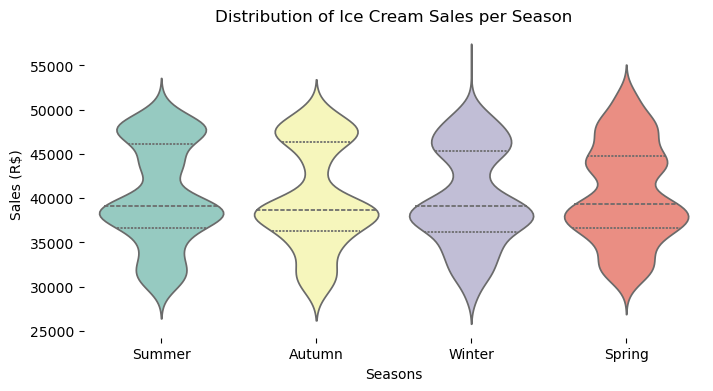

In [22]:
plt.subplots(figsize=(8, 4))

sns.violinplot(
    data=ice_cream_sales,
    x='season',
    y='total_sales',
    hue='season',
    palette='Set3',
    legend=False,
    inner='quart'
)

plt.xlabel('Seasons')
plt.ylabel('Sales (R$)')
plt.title('Distribution of Ice Cream Sales per Season')

sns.despine(left=True, bottom=True)

Analise sobre a temperatura em relação às estações do ano. Neste contexto foi utilizado um\
gráfico de violino em que a linha tracejada ao meio representa a mediana; linha a cima o\
terceiro quartil; linha abaixo, primeiro quartil.

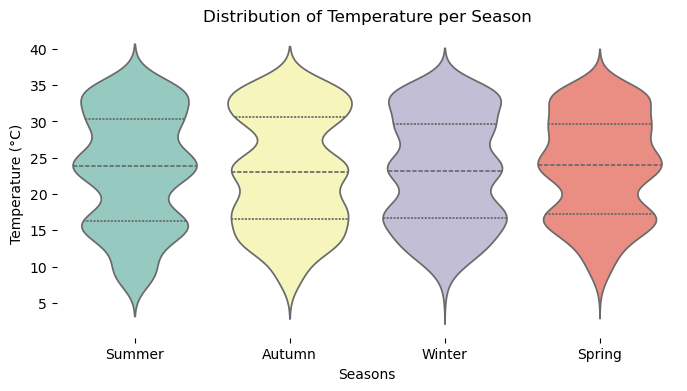

In [22]:
plt.subplots(figsize=(8, 4))

sns.violinplot(
    data=ice_cream_sales,
    x='season',
    y='temperature_celsius',
    hue='season',
    palette='Set3',
    legend=False,
    inner='quart'
)

plt.xlabel('Seasons')
plt.ylabel('Temperature (°C)')
plt.title('Distribution of Temperature per Season')

sns.despine(left=True, bottom=True)

#### 3.2)  Analise graficas bi variadas quanto à vendas e temperatura

Análise por meio de um gráfico de dispersão, com sua variante por contornos, a qual representa\
os pontos (venda por temperatura) com curvas de nível, ao passo que quanto maior a quantidade de\
contornos internos, maior concentração de pontos. Além disso, cada variável contínua tem sua função\
densidade calculado para adicionar informações que facilitam a análise uni e bi-variada.

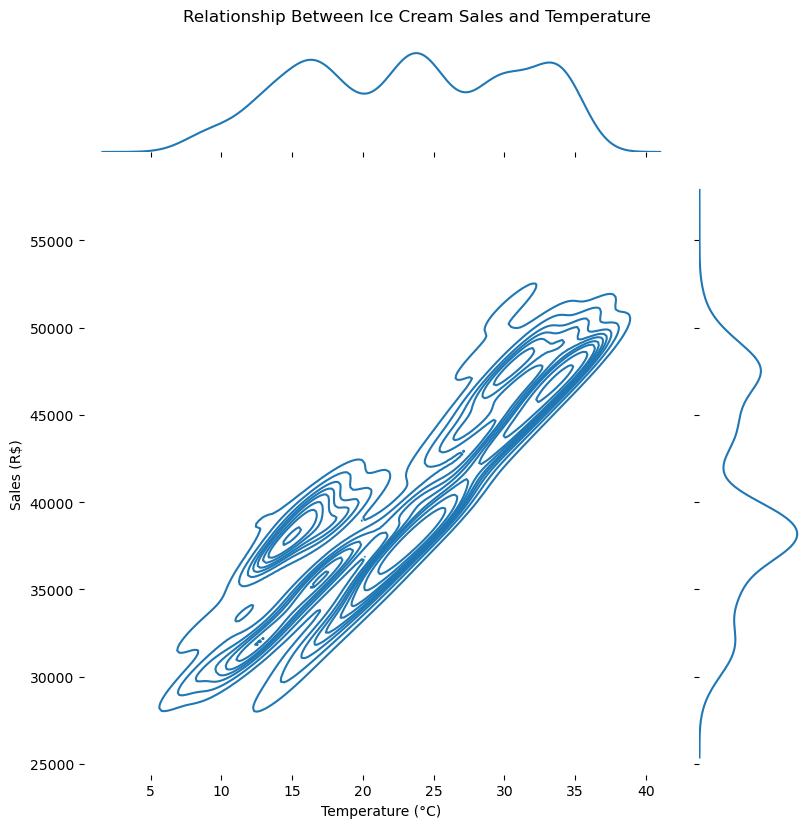

In [23]:
sns.jointplot(
   data=ice_cream_sales,
   y='total_sales',
   x='temperature_celsius',
   kind='kde',
   height=8,
)

plt.xlabel('Temperature (°C)')
plt.ylabel('Sales (R$)')
plt.suptitle('Relationship Between Ice Cream Sales and Temperature', y=1.03)

sns.despine(left=True, bottom=True)

**bônus**: análise bi-variada da quantidade vendas em relação ao tempo

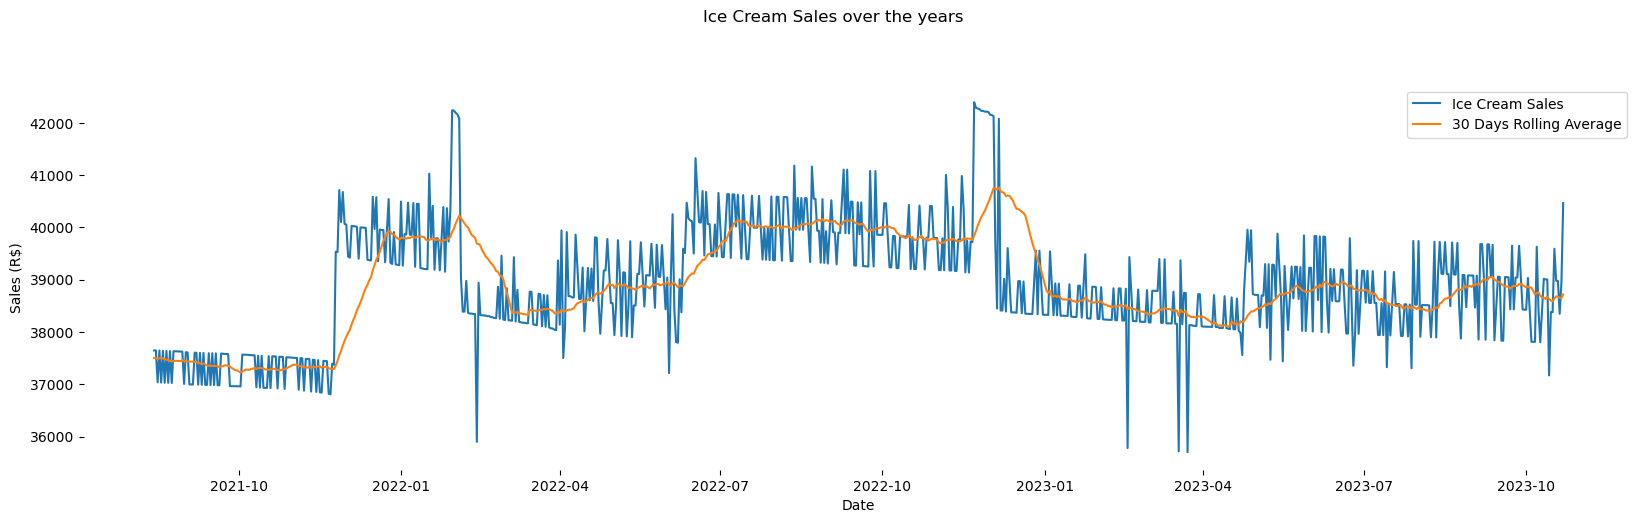

In [24]:
plt.subplots(figsize=(20,5))

sns.lineplot(
   data=ice_cream_sales.tail(800),
   y='total_sales',
   x='date',
   label='Ice Cream Sales',
)

sns.lineplot(
   data=ice_cream_sales.tail(800),
   y='30_days_rolling_mean_sales',
   x='date',
   label='30 Days Rolling Average',
)

plt.xlabel('Date')
plt.ylabel('Sales (R$)')
plt.suptitle('Ice Cream Sales over the years', y=1.03)

sns.despine(left=True, bottom=True)

**bônus**: análise bi-variada da temperature (°C) em relação ao tempo

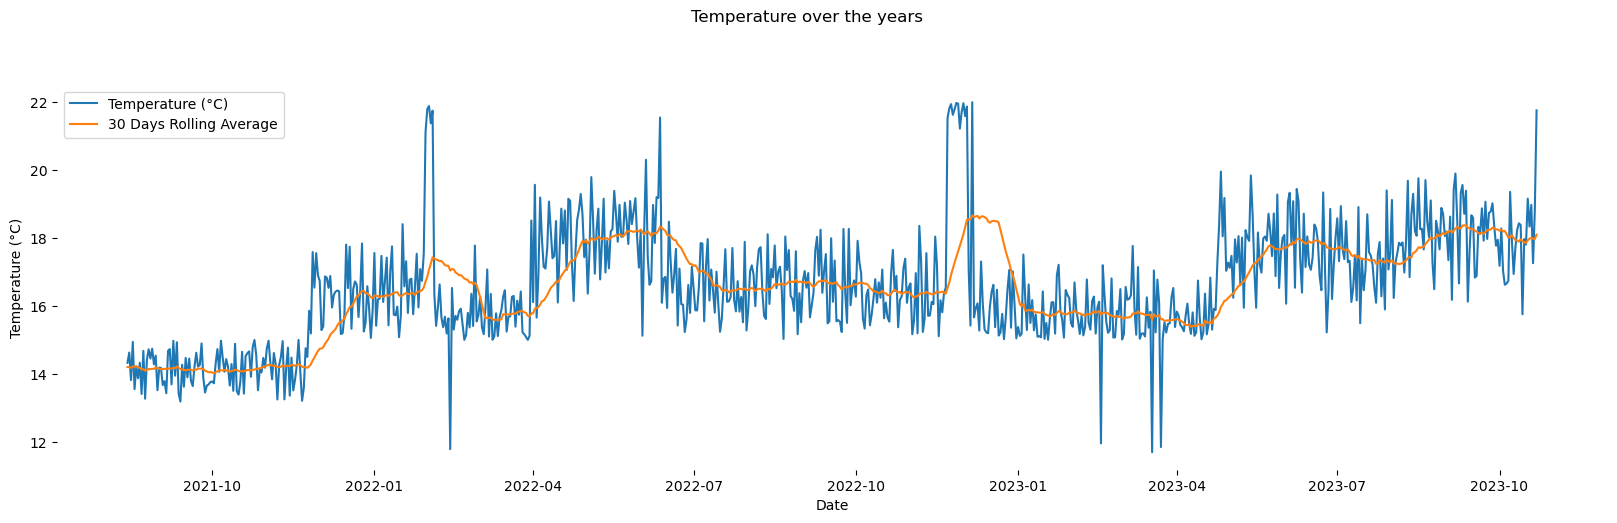

In [25]:
plt.subplots(figsize=(20,5))

sns.lineplot(
   data=ice_cream_sales.tail(800),
   y='temperature_celsius',
   x='date',
   label='Temperature (°C)',
)

sns.lineplot(
   data=ice_cream_sales.tail(800),
   y='30_days_rolling_mean_temperature',
   x='date',
   label='30 Days Rolling Average',
)

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.suptitle('Temperature over the years', y=1.03)

sns.despine(left=True, bottom=True)

#### 3.3) Correlação entre as variaveis _temperatura_ e _total de itens vendidos_

In [26]:
numeric_variabels = ice_cream_sales.drop(
    columns=[
        'day_of_week',
        'month_of_year',
        'week_of_month',
        'season',
        '30_days_rolling_mean_sales'
    ]
)
correlations = numeric_variabels.corr(method='pearson')
correlations.loc['total_sales', 'temperature_celsius']

0.9040588653750967

#### 3.4) Análise multi-variadas

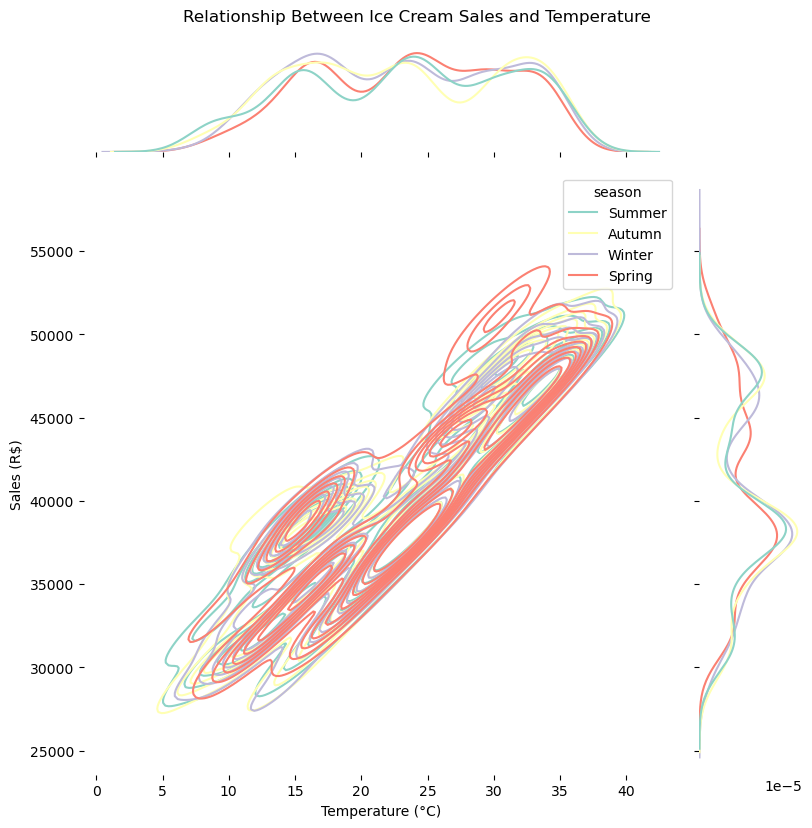

In [27]:
sns.jointplot(
   data=ice_cream_sales,
   y='total_sales',
   x='temperature_celsius',
   hue='season',
   palette='Set3',
   kind='kde',
   height=8,
)

plt.xlabel('Temperature (°C)')
plt.ylabel('Sales (R$)')
plt.suptitle('Relationship Between Ice Cream Sales and Temperature', y=1.03)

sns.despine(left=True, bottom=True)

---
## Análise preditiva

### 4) Defindo modelo de prediçãoa por meio uma Regressão Linear com penalização $\ell_1$

Foi utilizado o modelo de [Regressão Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso) (_Least Absolute Shrinkage and Selection Operator_), o qual consiste em\
aplicar uma regressão linear adicionando em sua função custo uma penalização $\ell_1$ para os coeficientes $\beta$.\
Isto faz com que os coeficientes lineares $\beta$ não significativos para predizer nossa variável dependente $y$ sejam\
reduzidos à zero. Isto acontece pois com a penalização $\ell_1$ penaliza valores altos para os coeficientes $\beta$, o que pode\
ser intensificado ao não pela constante $\alpha$; isto é, quanto maior o valor de $\alpha$, maior a penalização. Além disso, caso o\
valor de $\alpha$ tenda ao infinito, assintoticamente nossa função tenderá a um valor constante, o que representa, na prática,\
que o modelo se torna insensível à mudanças nas variáveis indepentestes ($x$).Dito isto, a escolha pela regressão Lasso \
deu-se um vez que o modelo de predição receberá três características, variáveis independentes, quais sejam: temperatura (°C),\
dia da semana e mês. Logo, a fim de encontrar quais variáveis independentes são mais significativas para o modelo de predição,\
optou-se pela Regressão Lasso em virtudo de sua capacidade de selecionar as variáveis mais significativas,descartando as\
variáveis menos significativas, ou reduzindo o valor de seus pesos $\beta$ para o cálculo final da variável dependente.

Assim, para além de encontrar a função que preverá o total de vendas de sorvete, a Regressão Lasso se utiliza a equação\
abaixo para encontrar as variáveis independentes mais significativas para o modelo, por meio da otimização dos coeficientes\
lineares $\beta$ que minimizem o valor de custo $J$. O custo $J$ é então calculado pela soma dos resísudos ao quadrado, isto é, a \
direfenteça entra o valor predito $\hat{y}$ com o valor real $y$, acrecido da penalização $\ell_1$ dos coeficientes lineares $\beta$. Além disso,\
especificamente na implementação da regressão Lasso da biblioteca [sk-learning](https://scikit-learn.org/stable/modules/linear_model.html#lasso) a soma dos resíduos ao quadrado é\
normalizada pela quantidade $n$ de variáveis indepentes $x$, para que o custo não diverja para conjuntos de dados com tamanhos distindos.\
Por fim a quantidade de variáveins independentes $n$ é multiplicado por $2$ para simplificar o cálculo da derivda da função custo $J$.

$
J(\beta) = \min\limits_{\beta \in \mathbb{R}^p} \{ \frac{1}{2n} ||y - \beta_0 - X\beta||^2_2 + \alpha ||\beta||_1 \}
$

Selecionando a matriz de variáveis indepentes $X$, contendo a temperatura em graus calsius e data de aferição,\
e o vetor com a variável dependente $y$ representando o total de vendas de sorvetes.

In [21]:
X = ice_cream_sales.loc[:, ['date', 'temperature_celsius']]
y = ice_cream_sales.loc[:, ['total_sales']].values.ravel()

Dividindo dados entre conjunto de trainamento, com 80% dos e registro; teste, 20%.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Criando função para extrair dia da semana e dia do mês da data de aferição

In [23]:
def get_date_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    A function to extract the day of week and the month of the year
    from a given date
    """
    X['day_of_week'] = X['date'].dt.day_of_week + 1
    X['week_of_month'] = X['date'].dt.day // 7 + 1
    X['month_of_year'] = X['date'].dt.month
    X['season'] = X['date'].apply(hp.get_season_as_number)
    X = X.drop(columns=['date'])
    
    return X

date_features = FunctionTransformer(get_date_features, validate=False)

Criando pipeline de transformações para os dados, para automatizar a extração de características baseadas na data de aferição

In [24]:
data_pipeline = Pipeline([
    ('date_features', date_features)
])

Ajustando dados de treinamento e aplicando transformações, posteriormente transformando dados de teste

In [25]:
X_train_pre = data_pipeline.fit_transform(X_train)
X_test_pre = data_pipeline.transform(X_test)

Treinando modelo de regressão Lasso com penalização L1, com $\alpha$ variando de $0.1$ a $1000$ com intervalos de $0.1$\
resultando em $10000$ valores de $\alpha$ para testar

In [38]:
grid_serch = GridSearchCV(
    estimator=Lasso(), 
    param_grid={'alpha': np.arange(0.1, 1000.1, 0.1)}, 
    cv=10,
    scoring='neg_root_mean_squared_error', 
    verbose=3,
    n_jobs=-1, 
    refit=True
)

Para obter-se o modelo mais otimizado, variando $\alpha$, a técnica de _cross validation_ foi empregada\
com $10$ _folds_, isto é, para cada valor de $\alpha$ treinou-se o modelo com $9$ _folds_, e calculando

In [39]:
grid_serch.fit(X_train_pre, y_train)

Fitting 10 folds for each of 10000 candidates, totalling 100000 fits


GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
       1.000e+03])},
             scoring='neg_root_mean_squared_error', verbose=3)

Melhor modelo

In [40]:
grid_serch.best_params_

{'alpha': 160.6}

In [41]:
optimal_lasso = grid_serch.best_estimator_

Salvando melhor modelo

In [42]:
joblib.dump(optimal_lasso, '../model/optimal-lasso.joblib')

['../model/optimal-lasso.joblib']

Realizando predições de total de vendas

In [43]:
y_train_pred = optimal_lasso.predict(X_train_pre)
y_test_pred = optimal_lasso.predict(X_test_pre)

Métrica de R² para conjunto de trainamento

In [44]:
r2_score(y_train, y_train_pred)

0.8158148364525213

Métrica de R² para conjunto de teste

In [45]:
r2_score(y_test, y_test_pred)

0.8230665165155082

Coeficientes $\beta$ para cada característica ($x$) juntamente com coeficiente de linear

In [49]:
feature_coef = pd.DataFrame({
    'feature_names': ['temperature_celsius', 'day_of_week', 'week_of_month', 'month_of_year', 'season', 'y_intercept'],
    'coefficient': np.append(optimal_lasso.coef_, optimal_lasso.intercept_)
})

feature_coef

,feature_names,coefficient
0,temperature_celsius,667.689705
1,day_of_week,-0.000000
2,week_of_month,0.000000
3,month_of_year,-0.000000
4,season,0.000000
5,y_intercept,24616.057692


A função que prevê o valor de vendas ($\hat{y}$) foi modelada com base na temperatura, dia da semana e mês do ano, por meio\
dos coeficientes angulares: $\beta_t$ que representa o coeficiente de temperatura; $\beta_d$, coeficiente de dia da semana e; $\beta_w$,\
coeficiente de semana do mês; $\beta_m$, coeficiente de mês do ano e; $\beta_s$, coeficiente de estação do ano. Já o coeficiente\
linear é representado por $\beta_0$. Por fim, as variáveis utilizadas como entrada desta função são temperatura, dia da semana\
semana do mês, mês do ano e estação do ano, repectivamente representados por $x_t$, $x_d$, $x_w$, $x_m$ e $x_s$.

$
\hat{y} = \beta_t * x_t + \beta_d * x_d + \beta_w * x_w + \beta_m * x_m + \beta_s * x_s + \beta_0 \\
$

Após o treinamento do modelo, por meio da técnica de Regressão Lasso, os coeficientes obtidos foram:

$
\beta_t \; = 667.689705 \\
\beta_d \ = 0 \\
\beta_w  = 0 \\
\beta_m = 0 \\
\beta_s \ = 0 \\
\beta_0 \ = 24616.057692
$

Ao fim do treinamento, foi obtido um $R_2$ de $0.8158148364525213$ para o conjunto de treinamento e\
um $R_2$ de $0.8230665165155082$ para o conjunto de tese.

---
## Inferências

### 5) Qual será o faturado na data de 30/out/23, sabendo que a previsao do tempo aponta para 18 °C

Criando um função para automatizar a transformação e inferência dos dados

In [26]:
loaded_model = joblib.load('../model/optimal-lasso.joblib')

In [27]:
def predict_sales(input_data: list[list]) -> list[float]:
    """
    A function to prepare the raw data to a proper way for prediction
    """
    instances = pd.DataFrame(data=input_data, columns=['date', 'temperature_celsius'])

    instances['date'] = instances['date'].astype('datetime64[ns]')
    instances['temperature_celsius'] = instances['temperature_celsius'].astype(pd.Float64Dtype())

    instances_preprocessed = data_pipeline.transform(instances)
    prediction = loaded_model.predict(instances_preprocessed)

    return prediction.tolist()

In [28]:
input_data = [['30-10-2023', 18]]
predict_sales(input_data)

[36634.472382105494]

O faturamento previsto para a data de 30/out/23, considerando uma temperatura de 18 °C, é de $36634.472382105494$

Visualizando inferência

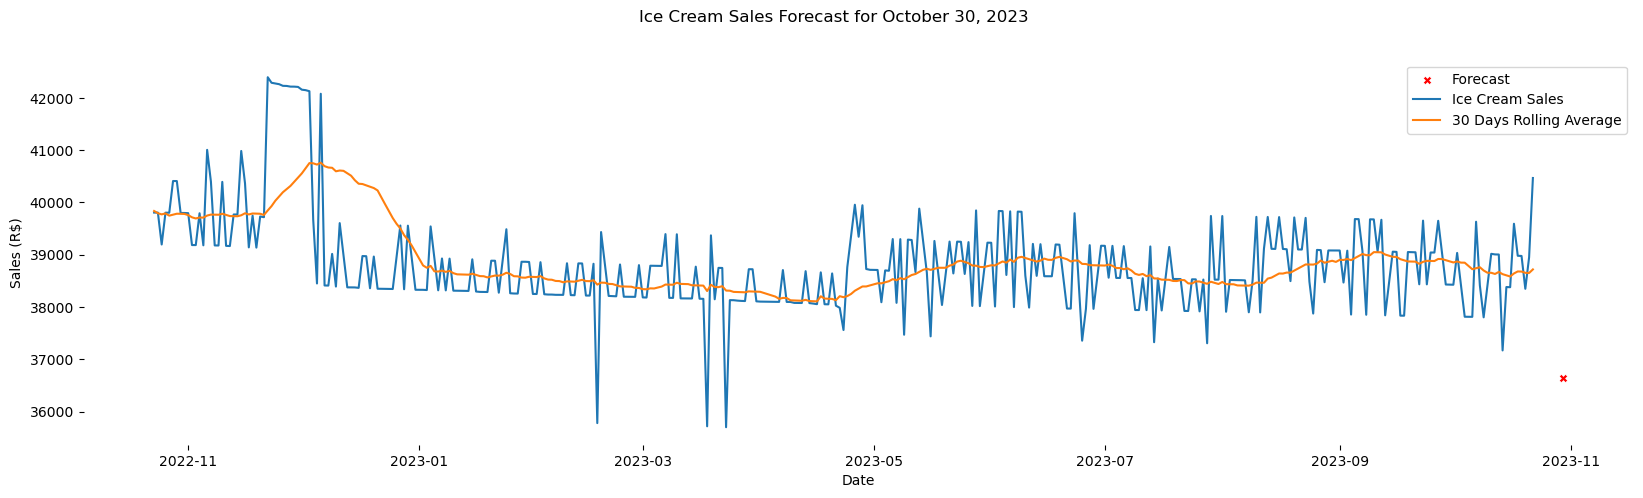

In [76]:
plt.subplots(figsize=(20,5))

sns.scatterplot(
    x=[datetime(2023, 10, 30)],
    y=[36634.472382105494],
    color='red',
    marker='X',
    label='Forecast'
)

sns.lineplot(
   data=ice_cream_sales.tail(365),
   y='total_sales',
   x='date',
   label='Ice Cream Sales',
)

sns.lineplot(
   data=ice_cream_sales.tail(365),
   y='30_days_rolling_mean_sales',
   x='date',
   label='30 Days Rolling Average',
)

plt.xlabel('Date')
plt.ylabel('Sales (R$)')
plt.suptitle('Ice Cream Sales Forecast for October 30, 2023')

sns.despine(left=True, bottom=True)

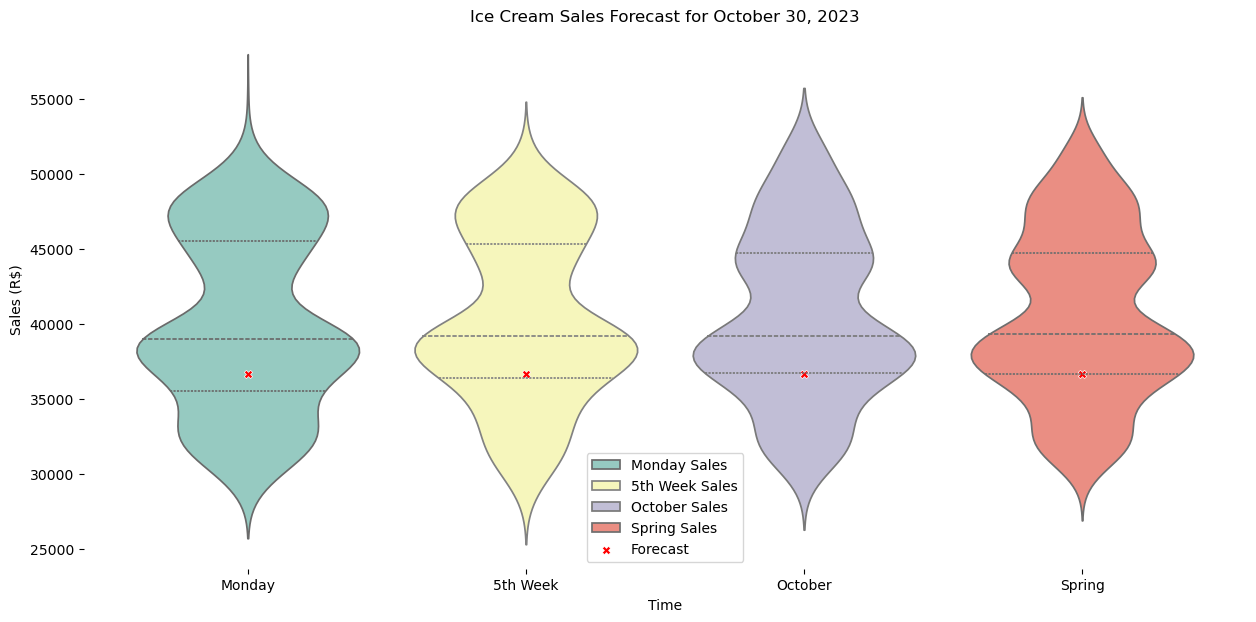

In [75]:
plt.subplots(figsize=(15, 7))

sns.violinplot(
    data=ice_cream_sales,
    x='day_of_week',
    y='total_sales',
    inner='quart',
    order=['Monday'],
    label='Monday Sales',
    color='#8dd3c7',
)

sns.violinplot(
    data=ice_cream_sales,
    x='week_of_month',
    y='total_sales',
    inner='quart',
    order=['5th Week'],
    label='5th Week Sales',
    color='#ffffb3',
)

sns.violinplot(
    data=ice_cream_sales,
    x='month_of_year',
    y='total_sales',
    inner='quart',
    order=['October'],
    label='October Sales',
    color='#bebada',
)

sns.violinplot(
    data=ice_cream_sales,
    x='season',
    y='total_sales',
    inner='quart',
    order=['Spring'],
    label='Spring Sales',
    color='#fb8072'
)

sns.scatterplot(
    x=['Monday', '5th Week', 'October', 'Spring'],
    y=[36634.472382105494]*4,
    color='red',
    marker='X',
    label='Forecast',
)

plt.xlabel('Time')
plt.ylabel('Sales (R$)')
plt.title('Ice Cream Sales Forecast for October 30, 2023')

sns.despine(left=True, bottom=True)

---
## Discutindo Resultados

### 6) Conlusão

### 7) Recomendação para o Diretor Fianceiro